[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [2]:
!pip install -U langchain-groq langchain-core langgraph


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.9 MB/s eta 0:00:00


## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation.

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`.

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Let's create a list of messages.

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [ ]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages
import os

# ------------------------------------------------------------------
# 1. Setup Groq API Key
# ------------------------------------------------------------------
os.environ["GROQ_API_KEY"] = ""

# ------------------------------------------------------------------
# 2. Create messages
# ------------------------------------------------------------------
messages = [
    AIMessage(content="So you said you were researching ocean mammals?", name="Model"),
    HumanMessage(content="Yes, that's right.", name="Lance"),
    AIMessage(content="Great, what would you like to learn about.", name="Model"),
    HumanMessage(content="I want to learn about the best place to see Orcas in the US.", name="Lance"),
]

for m in messages:
    m.pretty_print()

# ------------------------------------------------------------------
# 3. Initialize Groq model
# ------------------------------------------------------------------
# Choose a Groq-supported model (e.g., "llama3-8b-8192" or "mixtral-8x7b-32768")
llm = ChatGroq(model="openai/gpt-oss-120b")

# Test basic message invocation
result = llm.invoke(messages)
print("\n=== LLM Output ===")
print(result.content)

# ------------------------------------------------------------------
# 4. Define a tool
# ------------------------------------------------------------------
def multiply(a: int, b: int) -> int:
    """Multiply a and b."""
    return a * b

# Bind tool to model
llm_with_tools = llm.bind_tools([multiply])

# Example: asking the model to multiply
tool_call = llm_with_tools.invoke([HumanMessage(content="What is 2 multiplied by 3?")])
print("\n=== Tool Call Info ===")
print(tool_call.tool_calls)






================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.

=== LLM Output ===
### Top U.S. Spots for Seeing Orcas (Killer Whales)

| Rank | Location | Why It’s Prime Orca‑watching | Best Time of Year | Typical Tour Options |
|------|----------|-----------------------------|-------------------|----------------------|
| **1** | **San Juan Islands, Washington** (especially Friday Harbor & Lime Kiln) | • Highest concentration of resident “Southern Resident” pods (J‑Pod, K‑Pod, L‑Pod).<br>• Calm, sheltered wate

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple.

You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

In [8]:
# ------------------------------------------------------------------
# 5. Define graph state and reducer
# ------------------------------------------------------------------
class MyMessagesState(TypedDict):
    messages: Annotated[list, add_messages]

# ------------------------------------------------------------------
# 6. Define a node (function run by the graph)
# ------------------------------------------------------------------
def tool_calling_llm(state: MyMessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# ------------------------------------------------------------------
# 7. Build and compile the LangGraph
# ------------------------------------------------------------------
builder = StateGraph(MyMessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

## Our graph

Now, lets use `MessagesState` with a graph.

In [6]:
# ------------------------------------------------------------------
# 8. Test the graph
# ------------------------------------------------------------------
print("\n=== Conversation 1 ===")
messages = graph.invoke({"messages": [HumanMessage(content="Hello!")]})
for m in messages['messages']:
    m.pretty_print()

print("\n=== Conversation 2 (Tool Example) ===")
messages = graph.invoke({"messages": [HumanMessage(content="Multiply 2 and 3!") ]})
for m in messages['messages']:
    m.pretty_print()


=== Conversation 1 ===
================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?

=== Conversation 2 (Tool Example) ===
================================ Human Message =================================

Multiply 2 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_4f9c46f7-9a64-4606-b62b-5cf557efc110)
 Call ID: fc_4f9c46f7-9a64-4606-b62b-5cf557efc110
  Args:
    a: 2
    b: 3


#EXAMPLE SOLVED

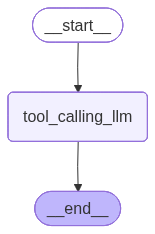


=== Example 1: Basic Conversation ===
================================ Human Message =================================

Hello, how are you today?
================================== Ai Message ==================================

Hello! I'm doing great, thank you for asking. How can I assist you today?

=== Example 2: Asking for a Math Operation ===
================================ Human Message =================================

Can you multiply 7 and 8 for me?
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_db0c54f3-f5d5-48c4-a4eb-bb7a53359883)
 Call ID: fc_db0c54f3-f5d5-48c4-a4eb-bb7a53359883
  Args:
    a: 7
    b: 8

=== Example 3: Using Area Tool ===
================================ Human Message =================================

What’s the area of a circle with radius 5?
================================== Ai Message ==================================
Tool Calls:
  get_area_of_circle (fc_e2aa06c7-54ee-4da8-9607-afb3d442f

In [12]:
import math
from IPython.display import Image, display
from datetime import datetime
# ------------------------------
# 🧰 Define Tools
# ------------------------------
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

def get_area_of_circle(radius: float) -> float:
    """Calculate area of a circle given its radius."""
    return round(math.pi * radius ** 2, 2)

def current_time() -> str:
    """Return the current date and time."""
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Bind all tools to the model
llm_with_tools = llm.bind_tools([multiply, get_area_of_circle, current_time])

# ------------------------------
# 🧱 Define Graph State
# ------------------------------
class MessagesState(TypedDict):
    messages: Annotated[list, add_messages]

# ------------------------------
# ⚙️ Define Node Function
# ------------------------------
def tool_calling_llm(state: MessagesState):
    """Process messages and allow the model to call bound tools."""
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

# ------------------------------
# 🕸️ Build the Graph
# ------------------------------
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# ------------------------------
# 🖼️ Visualize the Graph (Flow Image)
# ------------------------------
display(Image(graph.get_graph().draw_mermaid_png()))

# ------------------------------
# 🧑‍💬 Example 1 — Basic Chat
# ------------------------------
print("\n=== Example 1: Basic Conversation ===")
result = graph.invoke({"messages": [HumanMessage(content="Hello, how are you today?")]})
for msg in result["messages"]:
    msg.pretty_print()

# ------------------------------
# 🔢 Example 2 — Using a Tool (Math)
# ------------------------------
print("\n=== Example 2: Asking for a Math Operation ===")
result = graph.invoke({"messages": [HumanMessage(content="Can you multiply 7 and 8 for me?")]})
for msg in result["messages"]:
    msg.pretty_print()

# ------------------------------
# ⚪ Example 3 — Another Tool (Area Calculation)
# ------------------------------
print("\n=== Example 3: Using Area Tool ===")
result = graph.invoke({"messages": [HumanMessage(content="What’s the area of a circle with radius 5?")]})
for msg in result["messages"]:
    msg.pretty_print()

# ------------------------------
# 🕓 Example 4 — Time Query Tool
# ------------------------------
print("\n=== Example 4: Asking for Current Time ===")
result = graph.invoke({"messages": [HumanMessage(content="What is the current time right now?")]})
for msg in result["messages"]:
    msg.pretty_print()

# ------------------------------
# 💬 Example 5 — Context Carryover
# ------------------------------
print("\n=== Example 5: Context-Aware Conversation ===")
conversation = [
    HumanMessage(content="Hi there!"),
    AIMessage(content="Hello! What can I help you with today?"),
    HumanMessage(content="I’m learning about LangGraph. Can you give me a short summary?"),
]
result = graph.invoke({"messages": conversation})
for msg in result["messages"]:
    msg.pretty_print()

print("\n🎉 Done! You have now demonstrated:")
print(" - Groq LLM + LangGraph integration")
print(" - Multiple bound tools")
print(" - Stateful message-based conversation")
print(" - Graph visualization via Mermaid diagram")